In [2]:
import numpy as np
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numba
from numba import prange
from time import perf_counter
from scipy.ndimage import convolve, sobel
from scipy import ndimage
from scipy.special import xlogy
from sklearn import preprocessing
from scipy.stats import mode
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import seaborn as sns


# import statistics as statss
%matplotlib inline
sns.set_style("ticks")
sns.set_context("poster")

In [3]:
s = [[1,1,1],
     [1,1,1],
     [1,1,1]]

@numba.njit(parallel=True, fastmath=True)
def lap(u, N):
    """
    Parallel implementation of the laplacian operator with periodic boundary conditions.
    """
    uc = np.empty((N, N))
    for x in numba.prange(1, N-1):
        uc[x, 1:-1] = u[x+1, 1:-1] + u[x-1, 1:-1] + u[x, :-2] + u[x, 2:] - 4*u[x, 1:-1]

    uc[1:-1, 0] = u[1:-1, 1] + u[:-2, 0] + u[2:, 0] + u[1:-1, -1] - 4*u[1:-1, 0]
    uc[1:-1, -1] = u[1:-1, -2] + u[:-2, -1] + u[2:, -1] + u[1:-1, 0] - 4*u[1:-1, -1]
    uc[0, 1:-1] = u[1, 1:-1] + u[0, 2:] + u[0, :-2] + u[-1, 1:-1] - 4*u[0, 1:-1]
    uc[-1, 1:-1] = u[-2, 1:-1] + u[-1, 2:] + u[-1, :-2] + u[0, 1:-1] - 4*u[-1, 1:-1]

    uc[0, 0] = u[0, 1] + u[0, -1] + u[1, 0] + u[-1, 0] - 4*u[0, 0]
    uc[-1, 0] = u[0, 0] + u[-2, 0] + u[-1, -1] + u[-1, -2] - 4*u[-1, 0]
    uc[0, -1] = u[0, 0] + u[0, -2] + u[-1, -1] + u[1, -1] - 4*u[0, -1]
    uc[-1, -1] = u[0, -1] + u[-1, 0] + u[-1, -2] + u[-2, -1] - 4*u[-1, -1]
    return uc


@numba.njit(fastmath=True, parallel=True)
def gray_scott(U, V, Du, Dv, f, k, dt, dx, T):
    """
    Integrates the gray-scott system over time using the given initial
    conditions.
    """
    n = U.shape[0]
    iters = int(T / dt)
    for i in range(iters):
        Lu, Lv = Du*lap(U, n)/dx/dx, Dv*lap(V, n)/dx/dx
        U, V = U + dt*(Lu - U*V*V + f * (1-U)), V + dt*(Lv + U*V*V - (f+k) * V)
    return U, V

def gscott(n, F, k, T, Du=0.16, Dv=0.08, dt=1.0, dx=1.0, seed=5000000):
    """
    Wrapper function that initializes the U and V concentration arrays and the
    random number generator.
        
        n: dimensions of the discretized system
        F: value of F used for the model
        k: value of k used for the model
        T: number of time steps simulated
    
    """
    np.random.seed(seed=seed)
    U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
    r, m = n//40, n//2
    U[...] = 1.0
    V[m-r:m+r, m-r:m+r] = 0.25
    U[m-r:m+r, m-r:m+r] = 0.5
    U += np.random.normal(scale=0.05, size=U.shape)
    V += np.random.normal(scale=0.05, size=V.shape)
    return gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

def calc_objects(inp):
    """
    Calculates the number and size of objects in a given array.
    
    An array is returned with the size of each object, the length of the 
    array thus being the number of objects. A [0] array is returned if
    no objects are found.
    """
    fftding = np.fft.fft2(inp)
    outp = ndimage.fourier_ellipsoid(fftding, 1.1)*100
    outp = np.fft.ifft2(ndimage.fourier_gaussian(outp, 1.01)).real*10

    binarized1 = np.clip(outp-((outp.min() + outp.max())/2), 0, 1)
    labels1 = ndimage.label(binarized1, structure=s)
    binarized2 = np.clip((outp-((outp.min() + outp.max())/2))*-1, 0, 1)
    labels2 = ndimage.label(binarized2, structure=s)
    if labels1[1] > labels2[1]:
        bins, edges = np.histogram(labels1[0], bins=labels1[1])
        return bins[1:]

    # Try inversed region
    if labels2[1] > 1:
        bins, edges = np.histogram(labels2[0], bins=labels2[1])
        return bins[1:]
    
    # No objects
    return np.zeros(1)

def shannon_entropy(inp):
    """
    Calculates the entropy of an array with blob sizes.
    """
    if len(np.unique(inp)) < 2:
        return 0.0
    p = gaussian_kde(inp)
    return quad(lambda x: -p.pdf(x)*p.logpdf(x), -1000, 10000)[0]

def bulk_entropy(f, k, n=250, T=20000):
    """
    Computes a 2D entropy phase map over a given range of F and k.
    """
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    outp = np.zeros_like(f)
    for index, _f in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, _f, k[index], T)
        obj_u = calc_objects(u)
        outp[index] = shannon_entropy(obj_u)
    return outp

def bulk_entropy1d(f, k, n=250, T=20000):
    """
    Computes a 1D entropy trajectory over a range of points.
    """
    iters = len(f)
    
    outp = np.zeros_like(f)
    for index, _f in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, _f, k[index], T)
        obj_u = calc_objects(u)
        if obj_u.any():
            outp[index] = shannon_entropy(obj_u)
    return outp

# Complete entropy phase plot

/home/coen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:95: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


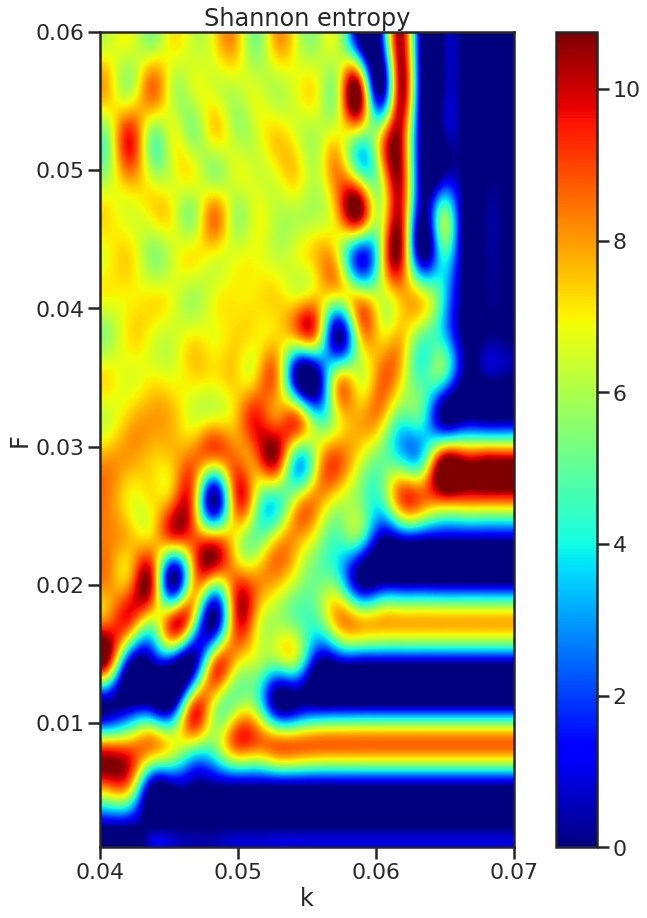

In [12]:
# Current parameters tuned for fast runtime ~ 5 min.

# Parameters used during project:
# f = np.linspace(0.001, 0.06, 150)
# k = np.linspace(0.04, 0.07, 150)

# outp = bulk_entropy(f, k)


f = np.linspace(0.001, 0.06, 20)
k = np.linspace(0.04, 0.07, 20)

outp = bulk_entropy(f, k, n=150, T=5000)

plt.figure(figsize=(15,15))
plt.imshow(outp.T, cmap='jet', origin='lower', interpolation='lanczos', extent=(k[0], k[-1], f[0], f[-1]))
plt.xlabel("k")
plt.ylabel("F")
plt.title("Shannon entropy")
plt.colorbar()
plt.show()

# Transition 1 phase plot

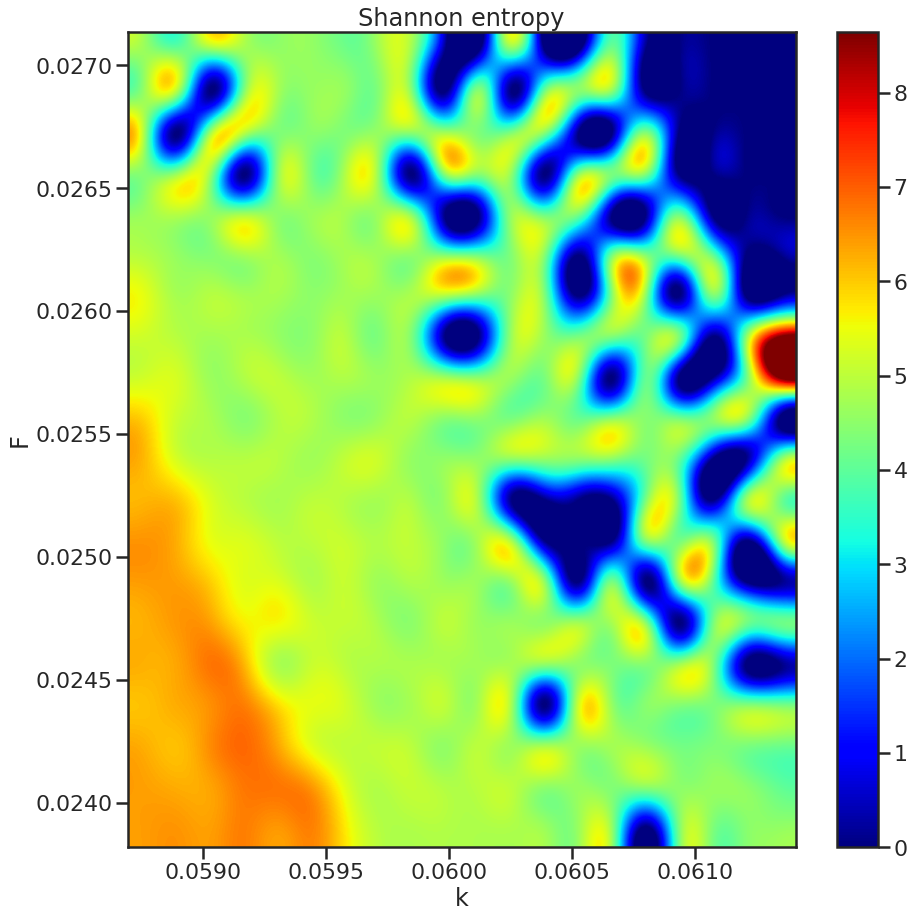

In [27]:
# Transition 1
# A F=0.0271360 k=0.06141
# D F=0.0238191 k=0.05869347

# Project parameters:
# f = np.linspace(0.0271360, 0.0238191, 100)[::-1]
# k = np.linspace(0.06141, 0.05869347, 100)[::-1]

# outp = bulk_entropy(f, k)

# Reversed to keep in line with global phase plot (low to high)
f = np.linspace(0.0271360, 0.0238191, 20)[::-1]
k = np.linspace(0.06141, 0.05869347, 20)[::-1]

outp = bulk_entropy(f, k, n=150, T=5000)


plt.figure(figsize=(15,15))
plt.imshow(outp.T, cmap='jet', interpolation='lanczos', extent=(k[0], k[-1], f[0], f[-1]))
plt.xlabel("k")
plt.ylabel("F")
plt.title("Shannon entropy")
plt.colorbar()
plt.show()

# Entropy over trajectory

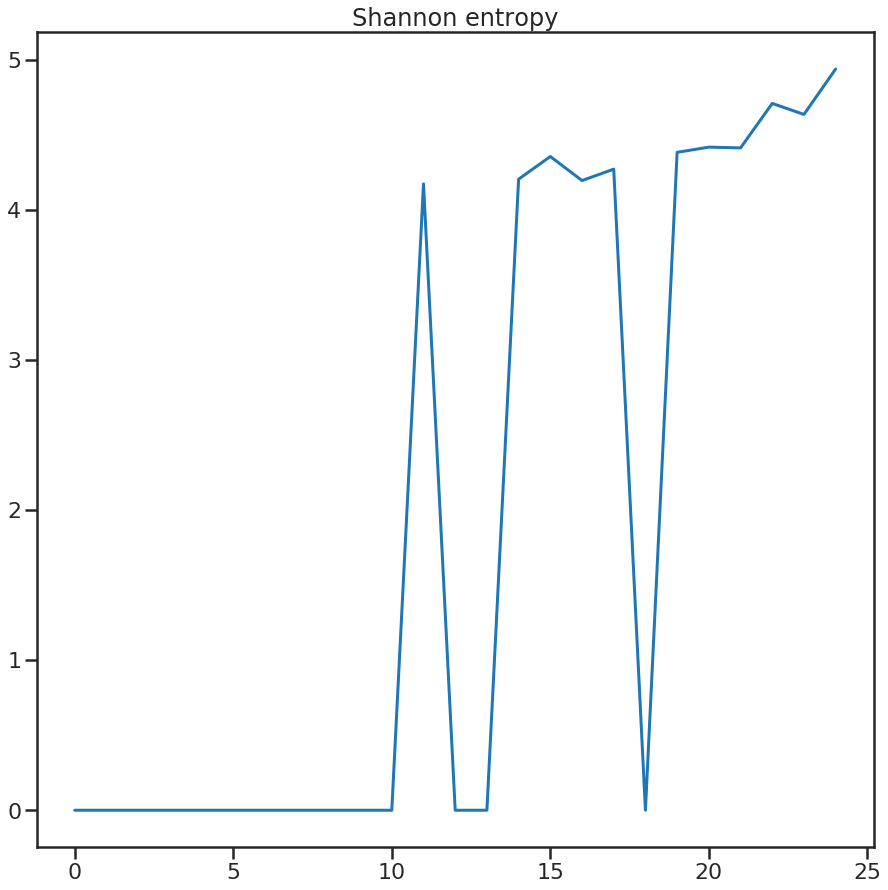

In [22]:
# f = np.linspace(0.0271360, 0.0238191, 250)
# k = np.linspace(0.06141, 0.05869347, 250)

f = np.linspace(0.0271360, 0.0238191, 25)
k = np.linspace(0.06141, 0.05869347, 25)


outp = bulk_entropy1d(f, k, n=250, T=20000)

# np.savetxt('entropy1', outp)

plt.figure(figsize=(15,15))
plt.plot(outp)
plt.title("Shannon entropy")
plt.show()

# Save all states of the trajectory to disk for gif creation

In [9]:
f = np.linspace(0.0271360, 0.0238191, 250)
k = np.linspace(0.06141, 0.05869347, 250)
gifding = np.zeros((250, 250, 250))
for i in tqdm(range(250)):
    gifding[i] = gscott(250, f[i], k[i], 20000)[0]
np.save('gifje1', gifding)

# Load entropy and fisher information from full run

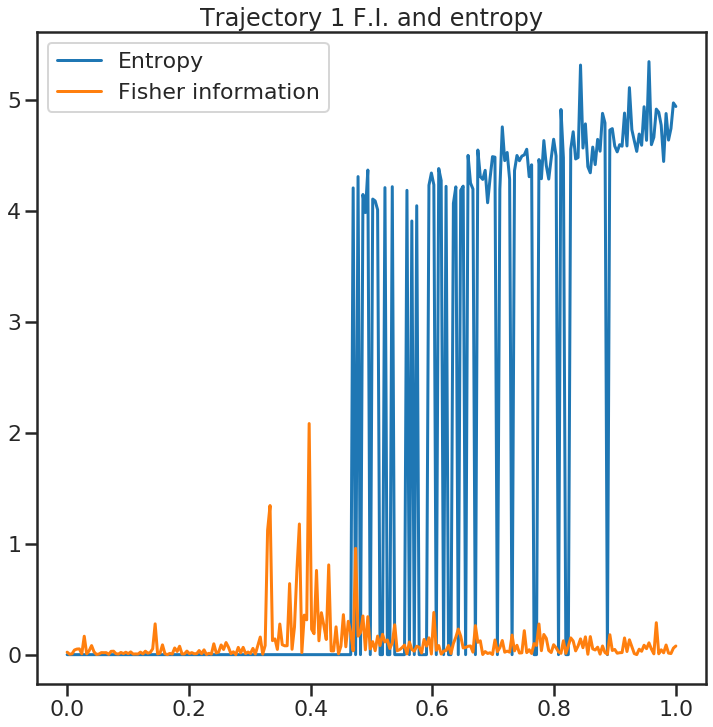

In [36]:
ds2 = np.loadtxt('ds2')[::-1] # Created in the fisher notebook
outp = np.loadtxt('entropy1')[::-1]

plt.figure(figsize=(12,12))
plt.title("Trajectory 1 F.I. and entropy")
plt.plot(np.linspace(0, 1, len(outp)),outp, label='Entropy')
plt.plot(np.linspace(0, 1, len(outp)),np.abs(ds2), label='Fisher information')
plt.legend()
plt.show()

# Phase plot of Trajectory 2 region

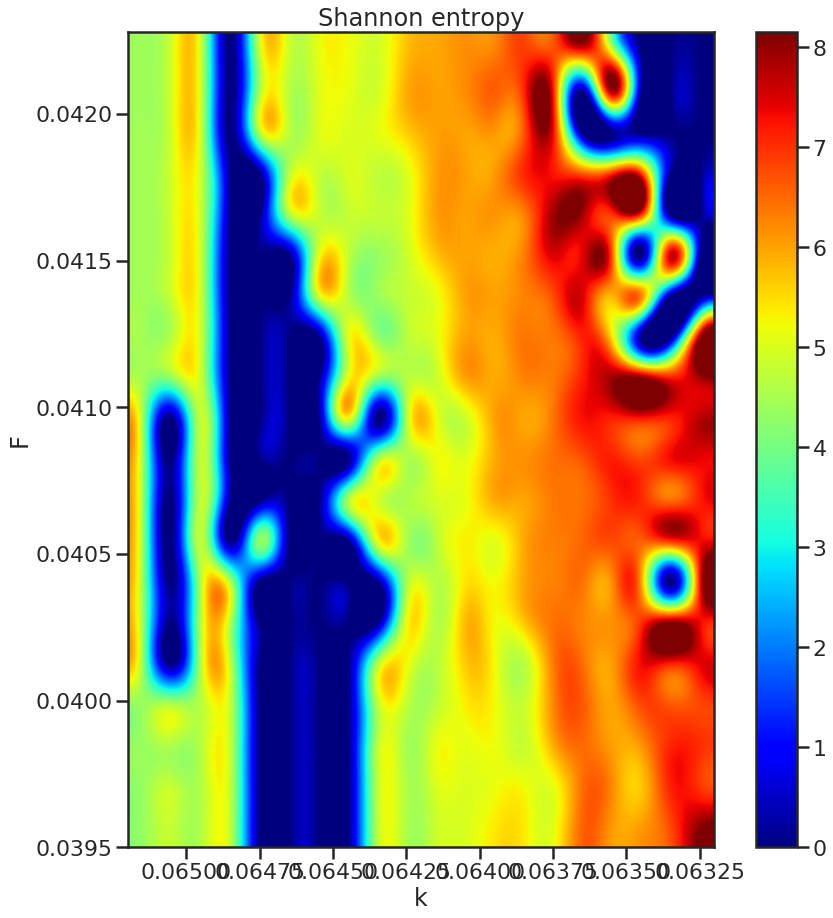

In [38]:
k = np.linspace(0.0652, 0.0632, 20)
f = np.linspace(0.0395, 0.04228, 20)


outp = bulk_entropy(f, k, n=150, T=5000)


plt.figure(figsize=(15,15))
plt.imshow(outp.T, cmap='jet', origin='lower', interpolation='lanczos', extent=(k[0], k[-1], f[0], f[-1]))
plt.xlabel("k")
plt.ylabel("F")
plt.title("Shannon entropy")
plt.colorbar()
plt.show()

# Entropy during trajectory 2

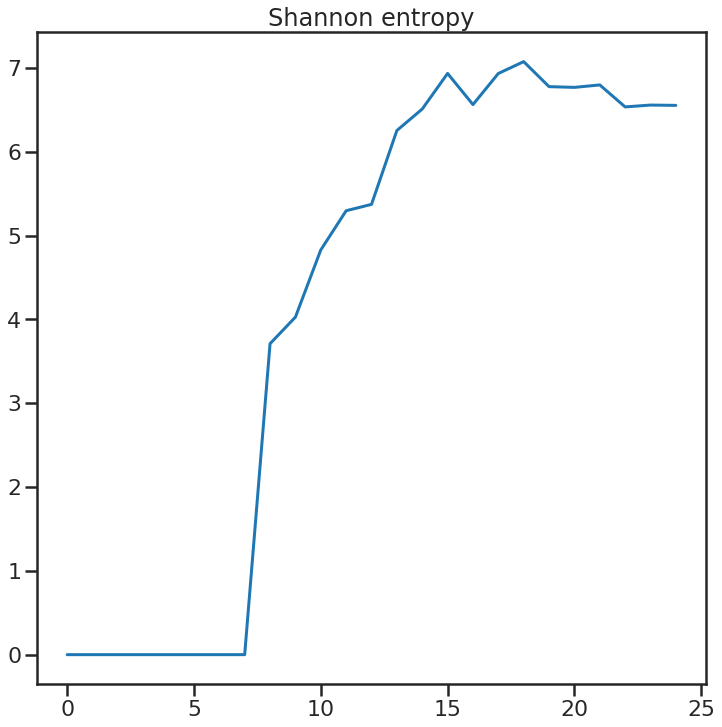

In [30]:
# k = np.linspace(0.0652, 0.0632, 250)
# f = np.linspace(0.0395, 0.04228, 250)

# outp2 = bulk_entropy1d(f, k)
# np.savetxt('entropy2', outp2)
k = np.linspace(0.0652, 0.0632, 25)
f = np.linspace(0.0395, 0.04228, 25)

outp2 = bulk_entropy1d(f, k)


plt.figure(figsize=(12,12))
plt.plot(outp2)
plt.title("Shannon entropy")
plt.show()

# Load entropy and Fisher from full run

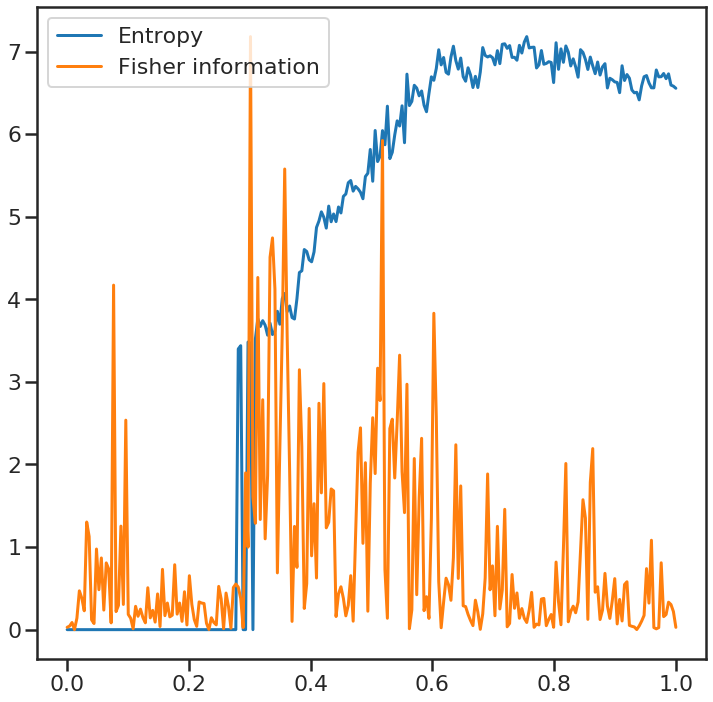

In [40]:
outp2 = np.loadtxt('entropy2')
ds2v2 = np.loadtxt('ds2v2')

ds2v2 = ds2v2 / np.max(ds2v2) * np.max(outp2)

plt.figure(figsize=(12,12))
plt.plot(np.linspace(0, 1, len(outp2)),outp2, label='Entropy')
plt.plot(np.linspace(0, 1, len(outp2)),ds2v2, label='Fisher information')
plt.legend()
plt.show()

# Save full run snapshots to disk for gif

In [8]:
k = np.linspace(0.0652, 0.0632, 250)
f = np.linspace(0.0395, 0.04228, 250)

gifding = np.zeros((250, 250, 250))
for i in tqdm(range(250)):
    gifding[i] = gscott(250, f[i], k[i], 30000)[0]
np.save('gifje2', gifding)